In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

In [2]:
from keras.models import load_model

Using TensorFlow backend.
/root/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [23]:
from scipy.ndimage.measurements import label

In [3]:
model = load_model('./models/mscnn1.h5')

In [4]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [63]:
def define_multiscale_window(img):
    y_start_stop = [int(0.5 * img.shape[0]), img.shape[0] -50]
    y_start_stop_small = [int(0.5 * img.shape[0]), int(0.6 * img.shape[0])]
    y_start_stop_med = [int(0.5 * img.shape[0]), int(0.8 * img.shape[0])]
    windowsizes = [32,64,128, 256]
    
    windows_small = slide_window(img, y_start_stop=y_start_stop_small, 
                    xy_window=(32, 32))
    windows_small2 =  slide_window(img, y_start_stop=y_start_stop_med, 
                    xy_window=(48, 48))
    windows_large1  =  slide_window(img, y_start_stop=y_start_stop, 
                    xy_window=(64,64))
    windows_large2 =  slide_window(img, y_start_stop=y_start_stop, 
                    xy_window=(128,128))
    return windows_small + windows_small2 + windows_large1 + windows_large2

def get_hot_boxes(img, windows, model):
    imgs = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        imgs.append(test_img)
    imgs = np.array(imgs)
    imgs_normed = imgs/255.
    cars_pred = np.argmax(model.predict(imgs_normed), axis=1)
    cars_windows_idx = np.nonzero(cars_pred > 0)
    boxes = []
    for i in cars_windows_idx[0]:
        boxes.append(windows[i])
    return boxes

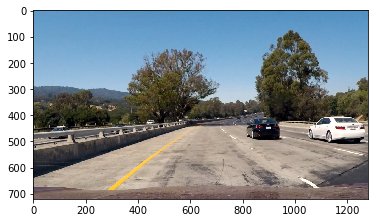

In [6]:
test1 = mpimg.imread('./test_images/test1.jpg')
plt.imshow(test1)

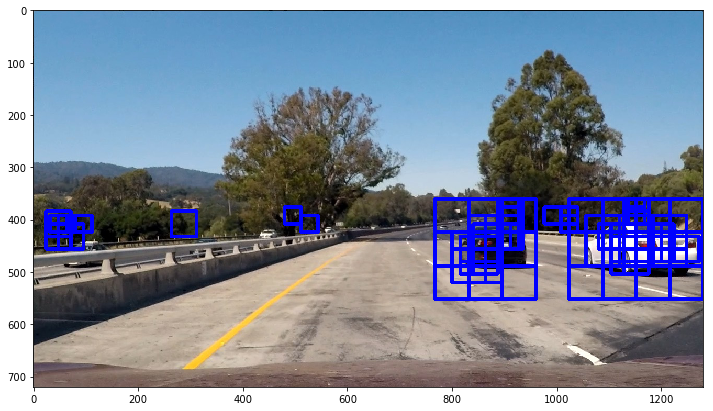

In [64]:
multiwindows = define_multiscale_window(test1)
outimg2 =get_hot_boxes(test1, multiwindows, model)
plt.figure(figsize=(12,8))
plt.imshow(draw_boxes(test1, outimg2))

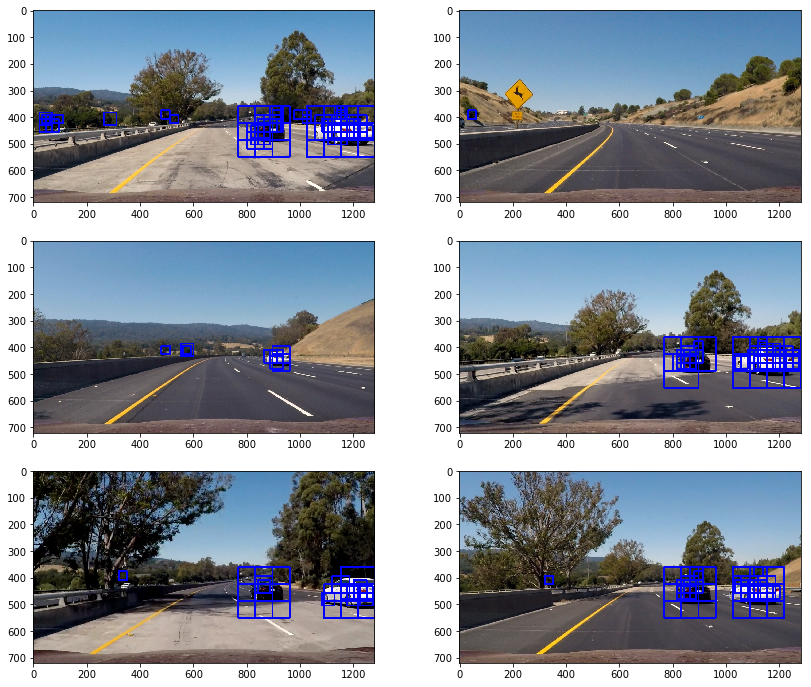

In [65]:
plt.figure(figsize=(14,12))
multiwindows = define_multiscale_window(test1)
for i in range(6):
    img = mpimg.imread('./test_images/test'+ str(i+1) +'.jpg')    
    outimg2 =get_hot_boxes(img, multiwindows, model)
    ax = plt.subplot(3,2, i + 1)
    ax.imshow(draw_boxes(img, outimg2))

In [66]:
def construct_heatmap(image, bounding_boxes, threshold = 0):
    heatmap = np.zeros_like(image[:,:,0])
    # Iterate through list of bboxes
    for box in bounding_boxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
    
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [67]:
heatmap = construct_heatmap(test1, outimg2, 2)

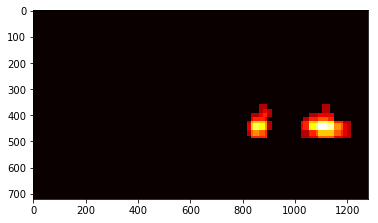

In [68]:
plt.imshow(np.clip(heatmap, 0, 255), cmap='hot')

In [69]:
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test1), labels)

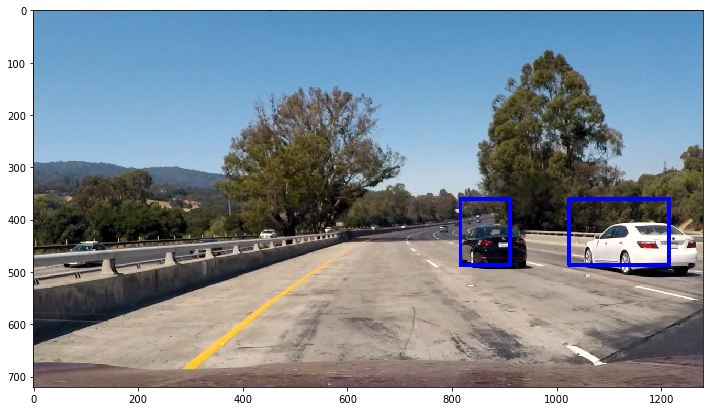

In [70]:
plt.figure(figsize=(12,9))
plt.imshow(draw_img)

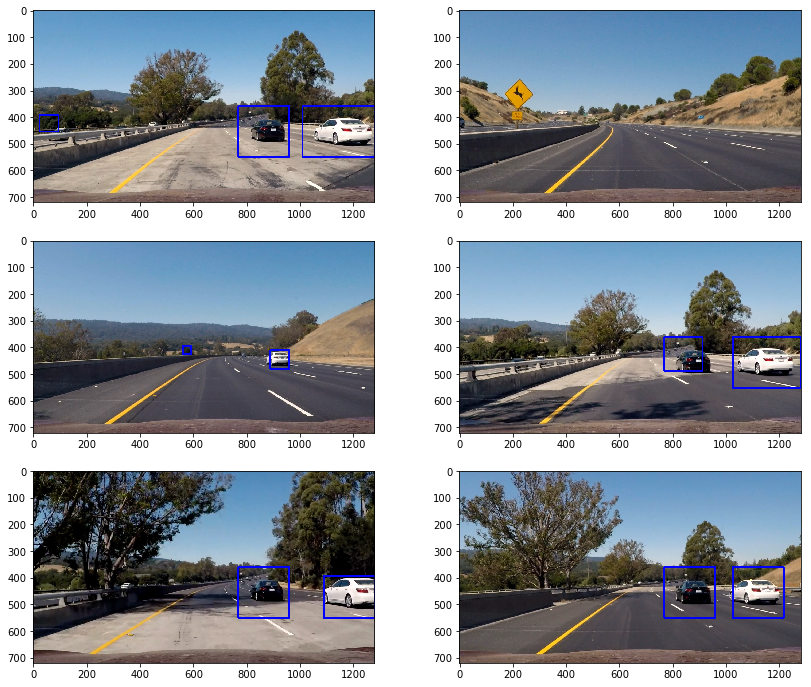

In [71]:
plt.figure(figsize=(14,12))
multiwindows = define_multiscale_window(test1)
for i in range(6):
    img = mpimg.imread('./test_images/test'+ str(i+1) +'.jpg')    
    outimg2 =get_hot_boxes(img, multiwindows, model)
    heatmap = construct_heatmap(img, outimg2, 2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    ax = plt.subplot(3,2, i + 1)
    ax.imshow(draw_img)

In [47]:
from moviepy.editor import VideoFileClip

In [72]:
def pipeline(img): 
    multiwindows = define_multiscale_window(img)
    hotboxes =get_hot_boxes(img, multiwindows, model)
    heatmap = construct_heatmap(img, hotboxes, 2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [74]:
input_video = 'project_video.mp4'
output_video = 'outvideo_test.mp4'
clip1 = VideoFileClip(input_video).subclip(0,40)
clipout = clip1.fl_image(pipeline)
clipout.write_videofile(output_video, audio=False, verbose=False, progress_bar=False)
